# Построение модели на примере полиномиальной регрессии (polynomial regression) с использованием `sklearn.pipeline`

## Подготовка окружения

In [ ]:
# ВНИМАНИЕ: необходимо удостовериться, что виртуальная среда выбрана правильно!

# Для MacOS/Ubuntu
# !which pip

# Для Windows
# !where pip

In [ ]:
# !conda install matplotlib numpy scikit-learn seaborn scipy -y

In [ ]:
# !conda install -c conda-forge imbalanced-learn

In [4]:
import numpy as np

np.__version__

'1.19.2'

In [5]:
import pandas as pd

pd.__version__

'1.2.3'

In [6]:
import scipy
from scipy import stats

scipy.__version__

'1.6.2'

In [7]:
import matplotlib
import matplotlib.pyplot as plt

matplotlib.__version__

'3.3.4'

In [8]:
import seaborn as sns

sns.__version__

'0.11.1'

In [9]:
import imblearn
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE

imblearn.__version__

'0.8.0'

In [10]:
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import classification_report

from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

from sklearn.metrics import roc_auc_score
from sklearn.metrics import plot_roc_curve
from sklearn.metrics import plot_precision_recall_curve

## Загрузка данных

[Источник (Churn Modelling)](https://www.kaggle.com/shrutimechlearn/churn-modelling)

In [11]:
df = pd.read_csv("./../../data/Churn_Modelling.csv", index_col=0)
df

,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
RowNumber,,,,,,,,,,,,,
1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9996,15606229,Obijiaku,771,France,Male,39,5,0.00,2,1,0,96270.64,0
9997,15569892,Johnstone,516,France,Male,35,10,57369.61,1,1,1,101699.77,0
9998,15584532,Liu,709,France,Female,36,7,0.00,1,0,1,42085.58,1


In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 1 to 10000
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   CustomerId       10000 non-null  int64  
 1   Surname          10000 non-null  object 
 2   CreditScore      10000 non-null  int64  
 3   Geography        10000 non-null  object 
 4   Gender           10000 non-null  object 
 5   Age              10000 non-null  int64  
 6   Tenure           10000 non-null  int64  
 7   Balance          10000 non-null  float64
 8   NumOfProducts    10000 non-null  int64  
 9   HasCrCard        10000 non-null  int64  
 10  IsActiveMember   10000 non-null  int64  
 11  EstimatedSalary  10000 non-null  float64
 12  Exited           10000 non-null  int64  
dtypes: float64(2), int64(8), object(3)
memory usage: 1.1+ MB


## Разделение данных на `X` и `y`

In [13]:
# колонка, которая не несет полезной информации
# если добавить, то может испортить качество, так как
# номер пользователя объективно не должен влиять на результ
del df['CustomerId']

In [14]:
target_column_name = 'Exited'

In [15]:
from sklearn.model_selection import train_test_split

y = df[target_column_name].copy()
X = df.loc[:, df.columns != target_column_name].copy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

## Этап 1 ("Straightforward")

### Анализ и обработка пропущенных значений

In [16]:
df.isna().sum()

Surname            0
CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Exited             0
dtype: int64

### Преобразование типов и очистка

In [17]:
for col_name in X_train.select_dtypes(include='object'):
    print(f'{col_name} : {X_train[col_name].nunique()}')
    print('-' * 20)

Surname : 2586
--------------------
Geography : 3
--------------------
Gender : 2
--------------------


In [18]:
for col_name in X_train.select_dtypes(include=int):
    nunique = X_train[col_name].nunique()
    
    print(f'{col_name} : {nunique}')
    if nunique < 40:
        display(X_train[col_name].value_counts())
    print('-' * 20)

CreditScore : 454
--------------------
Age : 70
--------------------
Tenure : 11


1     839
7     831
8     824
2     814
5     796
3     795
4     790
9     789
6     778
10    402
0     342
Name: Tenure, dtype: int64

--------------------
NumOfProducts : 4


1    4067
2    3682
3     202
4      49
Name: NumOfProducts, dtype: int64

--------------------
HasCrCard : 2


1    5632
0    2368
Name: HasCrCard, dtype: int64

--------------------
IsActiveMember : 2


1    4130
0    3870
Name: IsActiveMember, dtype: int64

--------------------


In [19]:
cat_columns = ['Gender', 'NumOfProducts']
# cat_columns = ['Gender']
bool_columns = ['HasCrCard', 'IsActiveMember']
num_columns = ['CreditScore', 'Age', 'Tenure', 'Balance', 'EstimatedSalary', 'NumOfProducts']
str_columns = ['Surname', 'Geography']

### Анализ баланса целевой переменной (`y`)

In [20]:
def plot_cat_count_s(cs: pd.Series):
    """
    Функция для рисования countplot для Series
    """
    fig, ax = plt.subplots(1, 1, figsize=(6, 2))
    g = sns.countplot(x=cs, 
                      ax=ax)
    g.set_xticklabels(g.get_xticklabels(), 
                      rotation=45, 
                      horizontalalignment='right')

    ax.xaxis.label.set_visible(False)
    ax.yaxis.label.set_visible(False)

    ax.set_title(cs.name, 
                 loc='right', 
                 fontsize=15)
    ax.grid()

    total = len(cs)
    
    print(f"{total} ({cs.name})")

    for p in ax.patches:
        percentage = '{:.1f}%'.format(100 * p.get_height()/total)
        x_pos = p.get_x()
        y_pos = p.get_y() + p.get_height()
        ax.annotate(percentage, 
                    xy=(x_pos, y_pos), 
                    fontsize=15)

10000 (Exited)


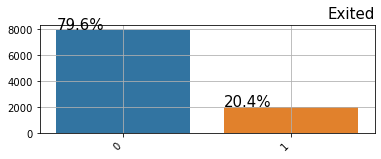

In [21]:
plot_cat_count_s(y)

Можно сказать, что имеется умеренная (moderate) несбалансированность классов.

### Анализ и обработка выбросов

In [22]:
def box_hist(data, col_name):
    _, axs = plt.subplots(1, 2, figsize=(10, 2))
    sns.boxplot(data=data[col_name], ax=axs[0])
    sns.histplot(data=data[col_name], ax=axs[1])

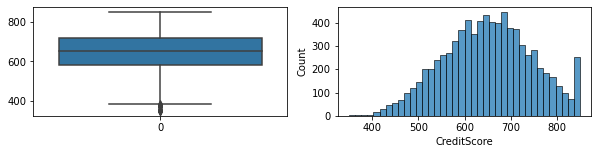

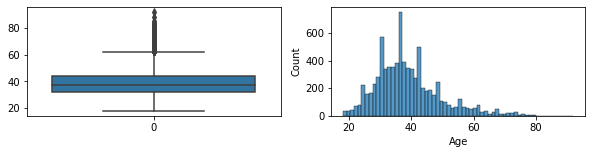

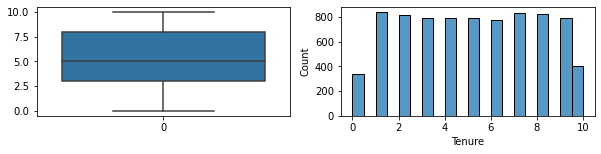

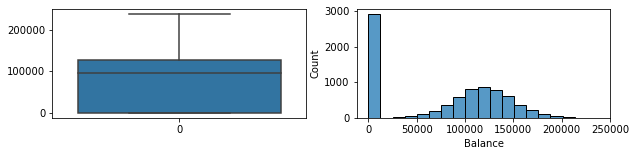

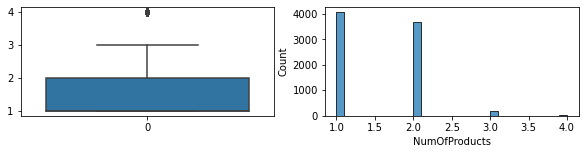

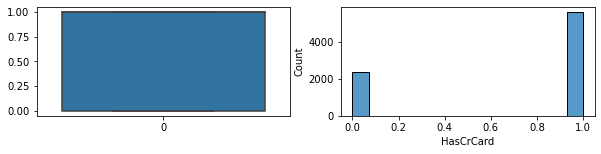

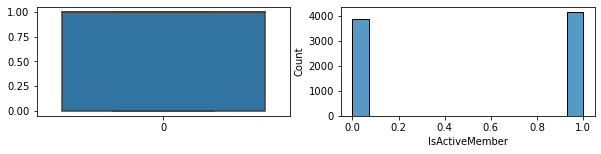

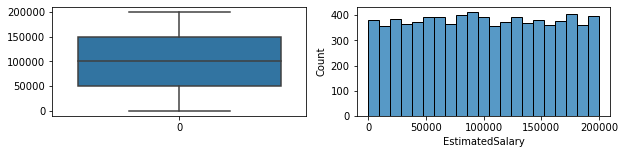

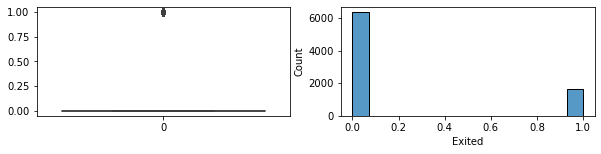

In [23]:
df_train = X_train.join(y_train).reset_index(drop=True)
for col_name in df_train.select_dtypes(include=np.number):
    box_hist(df_train, col_name)

X_train = df_train.loc[:, df_train.columns != target_column_name].copy()
y_train = df_train[target_column_name].copy()

## Анализ корреляции

In [24]:
corr_matrix = df_train.select_dtypes(include=np.number).corr(method='spearman')
corr_matrix[(abs(corr_matrix)) > 0.5]

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
CreditScore,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Age,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Tenure,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN
Balance,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN
NumOfProducts,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN
HasCrCard,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN
IsActiveMember,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN
EstimatedSalary,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN
Exited,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0


### Pipeline

In [25]:
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder

from sklearn.preprocessing import RobustScaler

from sklearn.tree import DecisionTreeClassifier

from sklearn.preprocessing import FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

In [26]:
# cat_columns = X_train.select_dtypes(include='category').columns.tolist()
bin_cat_columns = [col_name for col_name in X[cat_columns] if X[col_name].nunique() == 2]
mul_cat_columns = [col_name for col_name in cat_columns if col_name not in bin_cat_columns]
# bool_columns = X_train.select_dtypes(include='bool').columns.tolist()
bin_columns = bin_cat_columns + bool_columns

# num_columns = X_train.select_dtypes(include=np.number).columns.tolist()

# str_columns = X_train.select_dtypes(include='string').columns.tolist()

print(f"cat_columns: {cat_columns}\nbin_cat_columns: {bin_cat_columns}\nmul_cat_columns: {mul_cat_columns}\nbool_columns: {bool_columns}\nbin_columns: {bin_columns}")
print(f"num_columns: {num_columns}")
print(f"str_columns: {str_columns}")

cat_columns: ['Gender', 'NumOfProducts']
bin_cat_columns: ['Gender']
mul_cat_columns: ['NumOfProducts']
bool_columns: ['HasCrCard', 'IsActiveMember']
bin_columns: ['Gender', 'HasCrCard', 'IsActiveMember']
num_columns: ['CreditScore', 'Age', 'Tenure', 'Balance', 'EstimatedSalary', 'NumOfProducts']
str_columns: ['Surname', 'Geography']


In [27]:
bin_cat_transformer = Pipeline(steps=[
    ('encoder_ord', OrdinalEncoder())
])

In [28]:
mul_cat_transformer = Pipeline(steps=[
    ('replace', FunctionTransformer(lambda x: x.replace(4, 3)))
])

In [29]:
num_transformer = Pipeline(steps=[
    ('scaler', RobustScaler())
])

In [30]:
preprocessor = ColumnTransformer(
    transformers=[
        ('bin_cat_transformer', bin_cat_transformer, bin_columns),
        ('mul_cat_transformer', mul_cat_transformer, mul_cat_columns),
        ('num_transformer', num_transformer, num_columns),
        ('drop', 'drop', str_columns),
])

In [31]:
pipeline = Pipeline(steps = [
    ('preprocessor', preprocessor),
    ('model', DecisionTreeClassifier(criterion='entropy'))
])

In [32]:
X[bin_columns + mul_cat_columns + num_columns]

,Gender,HasCrCard,IsActiveMember,NumOfProducts,CreditScore,Age,Tenure,Balance,EstimatedSalary,NumOfProducts
RowNumber,,,,,,,,,,
1,Female,1,1,1,619,42,2,0.00,101348.88,1
2,Female,0,1,1,608,41,1,83807.86,112542.58,1
3,Female,1,0,3,502,42,8,159660.80,113931.57,3
4,Female,0,0,2,699,39,1,0.00,93826.63,2
5,Female,1,1,1,850,43,2,125510.82,79084.10,1
...,...,...,...,...,...,...,...,...,...,...
9996,Male,1,0,2,771,39,5,0.00,96270.64,2
9997,Male,1,1,1,516,35,10,57369.61,101699.77,1
9998,Female,0,1,1,709,36,7,0.00,42085.58,1


In [33]:
prep_for_test = preprocessor.fit(X_train, y_train)
pd.DataFrame(prep_for_test.transform(X_train), columns=bin_columns + mul_cat_columns + num_columns)

,Gender,HasCrCard,IsActiveMember,NumOfProducts,CreditScore,Age,Tenure,Balance,EstimatedSalary,NumOfProducts
0,1.0,1.0,1.0,2.0,-0.721805,-0.416667,-0.2,-0.761511,-0.461331,1.0
1,1.0,1.0,0.0,1.0,-0.947368,-0.083333,-0.4,-0.149969,-0.331268,0.0
2,1.0,0.0,1.0,1.0,-0.315789,-1.000000,1.0,-0.761511,0.101093,0.0
3,0.0,1.0,0.0,1.0,-0.406015,-1.083333,-0.8,0.048692,-0.400372,0.0
4,1.0,0.0,1.0,1.0,-0.045113,0.083333,-0.8,-0.227131,0.672440,0.0
...,...,...,...,...,...,...,...,...,...,...
7995,1.0,0.0,0.0,2.0,0.451128,0.083333,1.0,-0.761511,-0.472420,1.0
7996,0.0,1.0,0.0,2.0,-0.240602,0.333333,0.6,0.353216,0.145979,1.0
7997,1.0,1.0,0.0,2.0,0.796992,-1.166667,-0.6,-0.128275,-0.060101,1.0
7998,0.0,1.0,0.0,2.0,-0.120301,-0.333333,0.0,-0.761511,0.233410,1.0


[scoring parameter](https://scikit-learn.org/stable/modules/model_evaluation.html#common-cases-predefined-values)

In [34]:
# Параметры конвейеров могут быть заданы с использованием имен параметров, разделенных __
param_grid = {
    'model__max_depth': list(range(3, 8)),
    'model__min_samples_split': list(range(2, 8))
}
model_1 = GridSearchCV(pipeline, param_grid, n_jobs=-1, scoring='roc_auc')
model_1.fit(X_train, y_train)
print("Best parameter (CV score=%0.3f):" % model_1.best_score_)
print(model_1.best_params_)

Best parameter (CV score=0.834):
{'model__max_depth': 5, 'model__min_samples_split': 5}


In [35]:
from sklearn import set_config                      # to change the display
from sklearn.utils import estimator_html_repr       # to save the diagram into HTML format

# set config to diagram for visualizing the pipelines/composite estimators
set_config(display='diagram')

# saving pipeline as html format
with open('./tmp/pipeline.html', 'w') as f:
    f.write(estimator_html_repr(model_1.best_estimator_))

# the best estimator from grid search
model_1.best_estimator_

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('bin_cat_transformer',
                                                  Pipeline(steps=[('encoder_ord',
                                                                   OrdinalEncoder())]),
                                                  ['Gender', 'HasCrCard',
                                                   'IsActiveMember']),
                                                 ('mul_cat_transformer',
                                                  Pipeline(steps=[('replace',
                                                                   FunctionTransformer(func=<function <lambda> at 0x7f5969ef4b80>))]),
                                                  ['NumOfProducts']),
                                                 ('num_transformer',
                                                  Pipeline(steps=[('scaler',
                                                                   RobustScaler())]),
                                                  ['CreditScore', 'Age',
                                                   'Tenure', 'Balance',
                                                   'EstimatedSalary',
                                                   'NumOfProducts']),
                                                 ('drop', 'drop',
                                                  ['Surname', 'Geography'])])),
                ('model',
                 DecisionTreeClassifier(criterion='entropy', max_depth=5,
                                        min_samples_split=5))])

### Cross-validation

[sklearn.model_selection.cross_val_score](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_score.html)

In [36]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(model_1.best_estimator_, X_test, y_test, cv=5)
print(f"scores: {scores}")
print("%0.2f accuracy with a standard deviation of %0.2f" % (scores.mean(), scores.std()))

scores: [0.855  0.8625 0.845  0.8425 0.865 ]
0.85 accuracy with a standard deviation of 0.01


### Оценка качества модели (Evaluation)

In [37]:
def evaluate_model(model, X_test, y_test):
    y_predicted = model.predict(X_test)
    
    print(classification_report(y_test, y_predicted))
    
    accuracy = accuracy_score(y_test, y_predicted)
    precision = precision_score(y_test, y_predicted)
    recall = recall_score(y_test, y_predicted)
    f1 = f1_score(y_test, y_predicted, average='weighted')
    roc_auc = roc_auc_score(y_test, y_predicted)
    print(f"accuracy = {accuracy:.3f}\nprecision = {precision:.3f}\nrecall = {recall:.3f}\nf1 = {f1:.3f}\nroc_auc = {roc_auc:.3f}")
    
    _, axes = plt.subplots(1, 3, figsize=(20, 5))
    plot_confusion_matrix(model, X_test, y_test, ax=axes[0])
    plot_roc_curve(model, X_test, y_test, ax=axes[1])
    plot_precision_recall_curve(model, X_test, y_test, ax=axes[2])

              precision    recall  f1-score   support

           0       0.87      0.95      0.91      1589
           1       0.71      0.44      0.54       411

    accuracy                           0.85      2000
   macro avg       0.79      0.70      0.73      2000
weighted avg       0.84      0.85      0.83      2000

accuracy = 0.848
precision = 0.707
recall = 0.440
f1 = 0.833
roc_auc = 0.697


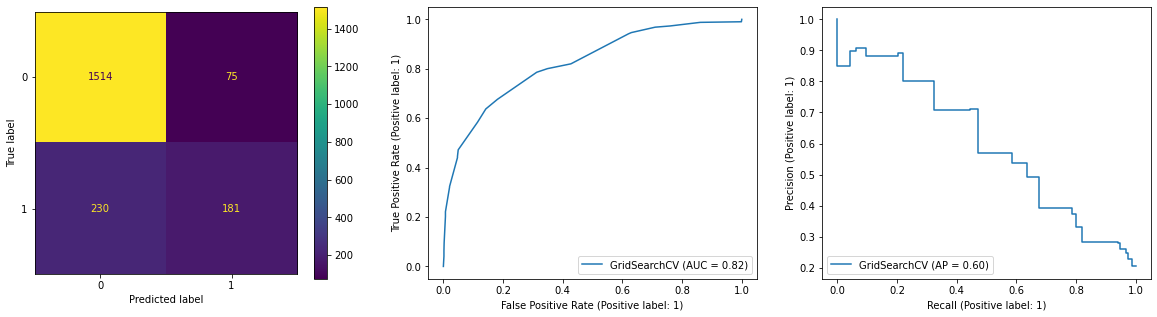

In [38]:
evaluate_model(model_1, X_test, y_test)

## Этап 2

### Балансировка классов (Oversampling)

In [39]:
from imblearn.pipeline import Pipeline

In [40]:
pipeline = Pipeline(steps = [
    ('preprocessor', preprocessor),
    ('over_sample', RandomOverSampler()),
    ('model', DecisionTreeClassifier(criterion='entropy'))
])

In [41]:
param_grid = {
    'model__max_depth': list(range(3, 8)),    
    'model__min_samples_split': list(range(2, 8)),
    'over_sample__sampling_strategy': list(np.arange(0.4, 1, 0.1))
}

model_2 = GridSearchCV(pipeline, param_grid, n_jobs=-1, scoring='roc_auc')
model_2.fit(X_train, y_train)
print("Best parameter (CV score=%0.3f):" % model_2.best_score_)
print(model_2.best_params_)

Best parameter (CV score=0.838):
{'model__max_depth': 5, 'model__min_samples_split': 5, 'over_sample__sampling_strategy': 0.7999999999999999}


### Cross-validation

[sklearn.model_selection.cross_val_score](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_score.html)

In [42]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(model_2.best_estimator_, X_test, y_test, cv=5)
print(f"scores: {scores}")
print("%0.2f accuracy with a standard deviation of %0.2f" % (scores.mean(), scores.std()))

scores: [0.85   0.8075 0.7675 0.7825 0.785 ]
0.80 accuracy with a standard deviation of 0.03


### Оценка качества модели (Evaluation)

              precision    recall  f1-score   support

           0       0.90      0.86      0.88      1589
           1       0.53      0.64      0.58       411

    accuracy                           0.81      2000
   macro avg       0.72      0.75      0.73      2000
weighted avg       0.83      0.81      0.82      2000

accuracy = 0.811
precision = 0.535
recall = 0.637
f1 = 0.817
roc_auc = 0.747


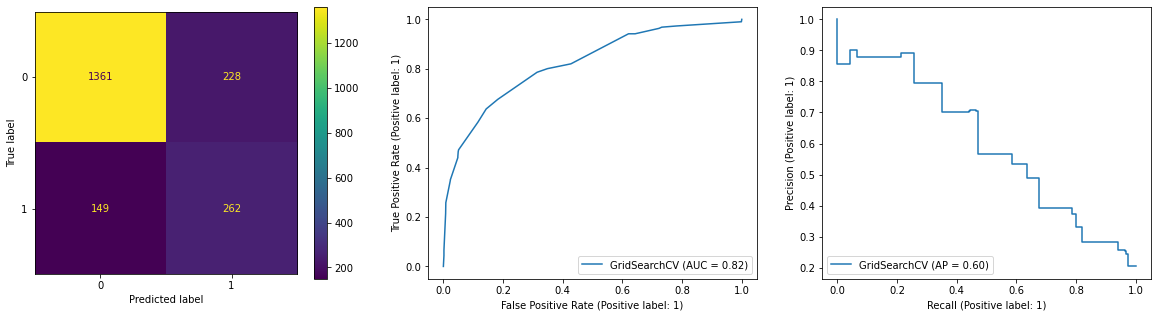

In [43]:
evaluate_model(model_2, X_test, y_test)

## Этап 3

### Балансировка классов (SMOTE)

In [44]:
from imblearn.pipeline import Pipeline

In [45]:
pipeline = Pipeline(steps = [
    ('preprocessor', preprocessor),
    ('over_sample', SMOTE()),
    ('model', DecisionTreeClassifier(criterion='entropy'))
])

In [46]:
param_grid = {
    'model__max_depth': list(range(3, 8)),    
    'model__min_samples_split': list(range(2, 8)),
    'over_sample__sampling_strategy': list(np.arange(0.4, 1, 0.1)),
    'over_sample__k_neighbors': list(range(3, 7))
}

model_3 = GridSearchCV(pipeline, param_grid, n_jobs=-1, scoring='roc_auc')
model_3.fit(X_train, y_train)
print("Best parameter (CV score=%0.3f):" % model_3.best_score_)
print(model_3.best_params_)

Best parameter (CV score=0.837):
{'model__max_depth': 6, 'model__min_samples_split': 6, 'over_sample__k_neighbors': 5, 'over_sample__sampling_strategy': 0.7999999999999999}


### Cross-validation

[sklearn.model_selection.cross_val_score](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_score.html)

In [47]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(model_3.best_estimator_, X_test, y_test, cv=5)
print(f"scores: {scores}")
print("%0.2f accuracy with a standard deviation of %0.2f" % (scores.mean(), scores.std()))

scores: [0.795  0.775  0.8125 0.77   0.7775]
0.79 accuracy with a standard deviation of 0.02


### Оценка качества модели (Evaluation)

              precision    recall  f1-score   support

           0       0.90      0.81      0.85      1589
           1       0.47      0.64      0.55       411

    accuracy                           0.78      2000
   macro avg       0.69      0.73      0.70      2000
weighted avg       0.81      0.78      0.79      2000

accuracy = 0.779
precision = 0.472
recall = 0.645
f1 = 0.791
roc_auc = 0.729


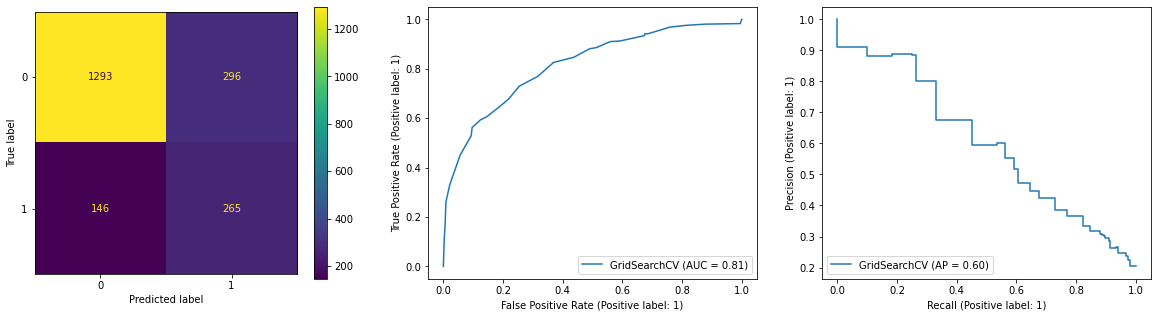

In [48]:
evaluate_model(model_3, X_test, y_test)

## Сравнение моделей

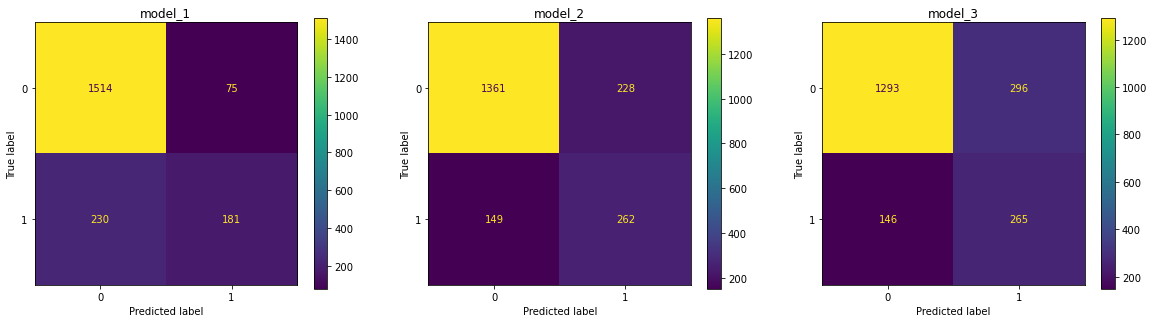

In [49]:
_, axes = plt.subplots(1, 3, figsize=(20, 5))
axes[0].set_title('model_1')
axes[1].set_title('model_2')
axes[2].set_title('model_3')

plot_confusion_matrix(model_1, X_test, y_test, ax=axes[0])
plot_confusion_matrix(model_2, X_test, y_test, ax=axes[1])
plot_confusion_matrix(model_3, X_test, y_test, ax=axes[2])